In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [2]:
# Function takes interatomic distance & returns qubit operator + more info

def get_qubit_op(dist):
    
    # define the molecule (LiH), and configure the interatomic distance for calculations
    #create a driver
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    
    #freeze core
    freeze_list = [0]
    #remove unoccupied orbitals
    remove_list = [-3, -2]
    
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

for dist in distances:
    
    # Qubit Operator
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    
    # Classical Exact Eigensolver
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.03967344173525 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313308880356205 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887035589697 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630945409912146 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720781099176417 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.7822115991796394 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568080575919 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.85066613181798 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529586249594 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.87696625444177 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.8809795073721824 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036615999848 Exact Ener

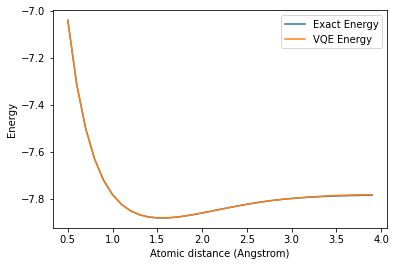

In [5]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()